## STOCK PRICING PREDICTION

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
%matplotlib inline
tf.set_random_seed(0)
print ("TENSORFLOW VERSION IS [%s]" % (tf.__version__))

TENSORFLOW VERSION IS [1.1.0]


## LOAD DATASET 

In [2]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)
xy = np.loadtxt('data/data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # REVERSE ORDER (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]
print ("SHAPE OF X IS %s" % (x.shape,))
print ("SHAPE OF Y IS %s" % (y.shape,))

SHAPE OF X IS (732, 5)
SHAPE OF Y IS (732, 1)


## DATASET HAS FIVE ITEMS
##### OPEN / HIGH / LOW / VOLUME / CLOSE
##### OBJECTIVE IS TO PREDICT 'CLOSE' GIVEN 7 PREVIOUS ITEMS

## BUILD A DATASET

In [3]:
timesteps = seq_length = 7
data_dim  = 5
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    dataX.append(_x)
    dataY.append(_y)
    if i == 0:
        print(" [INPUT]\n%s \n   =>\n [OUTPUT] \n%s" % (_x, _y))
print ()
print ("TYPE   OF    'dataX' IS [%s]." % (type(dataX)))
print ("LENGTH OF    'dataX' IS [%d]." % (len(dataX)))
print ("LENGTH OF 'dataX[0]' IS [%d]." % (len(dataX[0])))
print ()
print ("TYPE   OF    'dataY' IS [%s]." % (type(dataY)))
print ("LENGTH OF    'dataY' IS [%d]." % (len(dataY)))
print ("LENGTH OF 'dataY[0]' IS [%d]." % (len(dataY[0])))

 [INPUT]
[[  2.13751054e-01   2.08179810e-01   1.91791832e-01   4.66075110e-04
    1.92092403e-01]
 [  1.93935034e-01   2.03641926e-01   2.08664571e-01   2.98467330e-03
    1.96551555e-01]
 [  2.10516454e-01   2.05289413e-01   2.03558748e-01   2.59926504e-04
    1.87749731e-01]
 [  1.86678765e-01   2.09480567e-01   2.08781843e-01   0.00000000e+00
    2.17448151e-01]
 [  3.06973882e-01   3.14634137e-01   2.18993665e-01   1.24764722e-02
    2.16981885e-01]
 [  2.19142110e-01   2.63907214e-01   2.24686396e-01   4.56323384e-01
    2.24967473e-01]
 [  2.33129931e-01   2.36419163e-01   1.62682724e-01   5.70171193e-01
    1.47442742e-01]] 
   =>
 [OUTPUT] 
[ 0.13289962]

TYPE   OF    'dataX' IS [<type 'list'>].
LENGTH OF    'dataX' IS [725].
LENGTH OF 'dataX[0]' IS [7].

TYPE   OF    'dataY' IS [<type 'list'>].
LENGTH OF    'dataY' IS [725].
LENGTH OF 'dataY[0]' IS [1].


## SPLIT TRAIN (70%) AND TEST (30%) 

In [4]:
def print_np(_name, _x):
    print("TYPE  OF [%s] is [%s]" % (_name, type(_x)))
    print("SHAPE OF [%s] is %s" % (_name, _x.shape,))

In [5]:
train_size = int(len(dataY) * 0.7)
test_size  = len(dataY) - train_size
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
testX  = np.array(dataX[train_size:len(dataX)])
testY  = np.array(dataY[train_size:len(dataY)])
print_np('trainX', trainX)
print_np('trainY', trainY)
print_np('testX', testX)
print_np('testY', testY)

TYPE  OF [trainX] is [<type 'numpy.ndarray'>]
SHAPE OF [trainX] is (507, 7, 5)
TYPE  OF [trainY] is [<type 'numpy.ndarray'>]
SHAPE OF [trainY] is (507, 1)
TYPE  OF [testX] is [<type 'numpy.ndarray'>]
SHAPE OF [testX] is (218, 7, 5)
TYPE  OF [testY] is [<type 'numpy.ndarray'>]
SHAPE OF [testY] is (218, 1)


## TRAIN PARAMETERS

In [6]:
hidden_dim   = 10
output_dim   = 1
learing_rate = 0.01
iterations   = 500

## DEFINE MODEL

In [7]:
# PLACEHOLDERS
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])
# BUILD MODEL
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
print ("'X' LOOKS LIKE %s" % (X))
print ("'Y' LOOKS LIKE %s" % (Y))
print ("'OUTPUTS' LOOKS LIKE %s" % (outputs))

'X' LOOKS LIKE Tensor("Placeholder:0", shape=(?, 7, 5), dtype=float32)
'Y' LOOKS LIKE Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
'OUTPUTS' LOOKS LIKE Tensor("rnn/transpose:0", shape=(?, 7, 10), dtype=float32)


 NOTE THAT, INPUT TO A RNN SHOULD LOOK LIKE: 
 [BATCH, SEG_LENGTH, DATA_DIM]

## ADD DENSE LAYER FOR REGRESSION

In [8]:
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output
print ("'Y_PRED' LOOKS LIKE %s" % (Y_pred))

'Y_PRED' LOOKS LIKE Tensor("fully_connected/BiasAdd:0", shape=(?, 1), dtype=float32)


## DEFINE OPERATORS

In [9]:
# OPTIMIZER 
loss = tf.reduce_mean(tf.square(Y_pred - Y))  # sum of the squares
optm = tf.train.AdamOptimizer(learing_rate).minimize(loss)

# RMSE
targets     = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse        = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
print ("MODEL DEFINED")

MODEL DEFINED


## RUN

In [10]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
init = tf.global_variables_initializer()
sess.run(init)

# TRAIN
losses = []
for i in range(iterations):
    _, lossval = sess.run([optm, loss], feed_dict={
                            X: trainX, Y: trainY})
    losses.append(lossval)
    # print("[step: {}] loss: {}".format(i, step_loss))
print ("OPTIMIZATION FINISHED")

OPTIMIZATION FINISHED


### PLOT LOSS

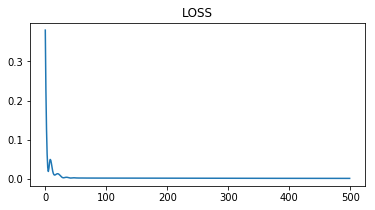

In [11]:
losslist = [_lossval for _lossval in losses]
plt.figure(figsize=(6, 3))
plt.plot(losslist, label='With BN')
plt.title("LOSS")

## TEST

In [12]:
test_predict = sess.run(Y_pred, feed_dict={X: testX})
rmse = sess.run(rmse, feed_dict={
                targets: testY, predictions: test_predict})
print_np('testX', testX)
print_np('test_predict', test_predict)
print("RMSE: {}".format(rmse))

TYPE  OF [testX] is [<type 'numpy.ndarray'>]
SHAPE OF [testX] is (218, 7, 5)
TYPE  OF [test_predict] is [<type 'numpy.ndarray'>]
SHAPE OF [test_predict] is (218, 1)
RMSE: 0.0291022937745


### Plot predictions

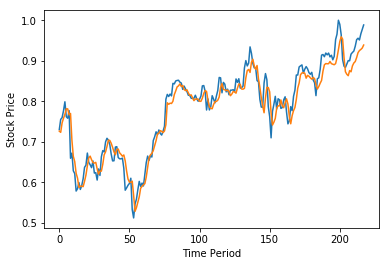

In [13]:
plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()